In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from sklearn.feature_selection import SelectKBest, f_classif

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree

Let's check how many missing values has our dataset per feature.

In [4]:
df = pd.read_csv("data.csv")
df.isnull().sum()

ID             0
survived       0
pclass         0
name           0
sex            0
age          204
sibsp          0
parch          0
ticket         0
fare           1
cabin        771
embarked       1
home.dest    425
dtype: int64

There are more than 50% missing values in 'Cabin' and let's delete this feature. Also, we could delete 'home.dest'.
We have to do something about the NaN values in the Age column. We can replace them with the mean of the age, but that would mean that some kid (Master or Miss) would appear to be older than they are. So we will take the mean of the age from each Title, and then replace each NaN value with the mean of the age of the corresponding persons title. Also, I assumed that the average male age depends on the class of the cabin (older menusually have more wealth)


**note:**
Master is an English honorific for boys and young men (<12).
https://en.wikipedia.org/wiki/Master_(form_of_address)

In [5]:
#extract median value for females
age_median_miss = df[df['name'].str.contains("Miss.")]['age'].median()
age_median_mrs = df[df['name'].str.contains("Mrs.")]['age'].median()
print("The mediane age for Miss:{0}, Mrs.:{1}".format(age_median_miss, \
                                                               age_median_mrs))
#extract median value for males
print("For Mr. min age: {0}, max age: {1}".format(df[df['name'].str.contains("Mr.")]['age'].min(), \
                                                 df[df['name'].str.contains("Mr.")]['age'].max()))
male_age = df[df['name'].str.contains("Mr.")].groupby(['pclass'])['age'].median()
print('Mr. median age depending on the class:')
print(male_age)

fares = df.groupby("pclass")["fare"].median()
embarked_f = df['embarked'].mode()

The mediane age for Miss:22.0, Mrs.:35.0
For Mr. min age: 11.0, max age: 80.0
Mr. median age depending on the class:
pclass
1    42.0
2    30.0
3    27.0
Name: age, dtype: float64


Other fields we will replace with median value or most frequent value.

In [6]:
def preprocessing(df):
    #replacement with the most frequent
    df['embarked'].mask(df['embarked'].isnull(), df['embarked'].fillna(embarked_f), inplace = True)
    #there may be errors in the data, replace them with the most frequent
    df['embarked'].mask(~df['embarked'].isin(['S', 'C', 'Q']), df['embarked'].fillna(embarked_f), inplace = True)

    df['fare'] = df.apply(lambda x: fares[x["pclass"]] if pd.isnull(x["fare"]) else x['fare'], axis=1)

    #extract ticket number as a digit
    df['ticket'] = df['ticket'].str.findall(r'(\d{2,})').str[-1]
    df['ticket'].mask(df['ticket'].isnull(), df['ticket'].fillna(0), inplace = True)
    #create bins for age
    bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 100]
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    df['age'] = pd.cut(df['age'], bins=bins, labels=labels)
    ##one hot encoding
    df = pd.get_dummies(df, columns=['pclass', 'age', 'sex', 'embarked'])
    df_drop = df.drop(['cabin', 'home.dest', 'ID', 'name'], axis=1)
    return df_drop

In [7]:
df_drop = preprocessing(df)
target = df_drop['survived']
train = df_drop.drop(['survived'], axis=1)

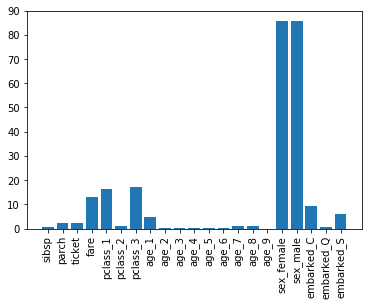

In [8]:
from sklearn.feature_selection import SelectKBest
predictors = list(train.columns.values)
selector = SelectKBest(f_classif, k=5)
selector.fit(train, target)

scores = -np.log10(selector.pvalues_)

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

The target variable is most affected by gender. Also, the chances of survival for youngsters and first class are higher.

Let's check these assumptions on the charts

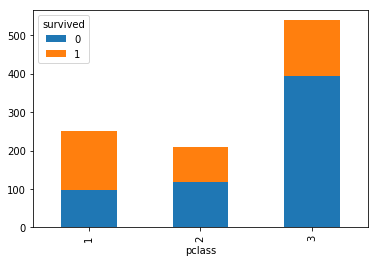

In [9]:
df.pivot_table('ID', 'pclass', 'survived', 'count').plot(kind='bar', stacked=True)

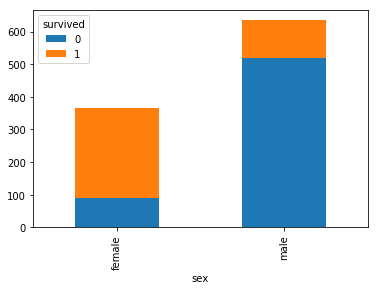

In [10]:
df.pivot_table('ID', 'sex', 'survived', 'count').plot(kind='bar', stacked=True)

In [11]:
# data normalization using StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train_scale = scaler.transform(train)

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [23]:
train_scale[0][0] = np.nan

To search for the best hyperparameters for models use the gridSearch.
cv : cross-validation generator or an iterable

In [13]:
# Knn with the search for the optimal number of neighbors.
parameters = {'n_neighbors':range(1,10)}
knn = GridSearchCV(KNeighborsClassifier(), parameters, cv=10, n_jobs=-1)
knn.fit(train_scale, target)
knn_model = knn.best_estimator_
print("k-neighbors: best score- {}, best params- {}".format(knn.best_score_, knn.best_params_))

k-neighbors: best score- 0.8, best params- {'n_neighbors': 8}


In [19]:
# C-Support Vector Classification with different kernels
from sklearn.svm import SVC
parameters = {'kernel':['linear', 'rbf', 'poly']}
alg_svm = GridSearchCV(SVC(), parameters, cv=10, n_jobs=-1)
alg_svm.fit(train_scale, target)
svm_model = alg_svm.best_estimator_
print("SVM: best score- {}, best params- {}".format(alg_svm.best_score_, alg_svm.best_params_))

SVM: best score- 0.812, best params- {'kernel': 'poly'}


In [20]:
#Random forest with the selection of the optimal number of trees and tree depth.
from sklearn.ensemble import RandomForestClassifier
parameters = [{
    'max_depth': range(2,10),
    "n_estimators": [10, 30, 60, 100, 250, 500],
#   "min_samples_split": [4, 6, 8, 10],
#   "min_samples_leaf": [1, 2, 4]
}]
rf = GridSearchCV(RandomForestClassifier(), parameters, cv=5, n_jobs=-1)
rf.fit(train_scale, target)
rf_model = rf.best_estimator_
print("Random forest: best score- {}, best params- {}".format(rf.best_score_, rf.best_params_))

Random forest: best score- 0.821, best params- {'n_estimators': 30, 'max_depth': 6}


In [21]:
# Logistic regression without params :)
alg_log = LogisticRegression(random_state=1)
scores = cross_val_score(alg_log, train_scale, target, cv=10, n_jobs=-1,)
print("Accuracy (logistic regression): {}/{}".format(scores.mean(), scores.std()))
alg_log.fit(train_scale, target)

Accuracy (logistic regression): 0.8040059005900592/0.0417209153398989


c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
# load data for validation and preprocessing
evaluation_data = pd.read_csv("evaluation.csv")
eval_preproc = preprocessing(evaluation_data)
eval_scale = scaler.transform(eval_preproc)

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
y_dec_tree = dt_model.predict(eval_scale)
y_pred_knc = knn_model.predict(eval_scale)  
y_pred_rf = rf_model.predict(eval_scale)  
y_pred_svm = svm_model.predict(eval_scale)  
y_alg_log = alg_log.predict(eval_scale) 

In [24]:
#save to file
np.savetxt('results_knn.csv',y_alg_log, delimiter=',', fmt ='%.0f')
np.savetxt('results_svm.csv',y_pred_svm, delimiter=',', fmt ='%.0f')
np.savetxt('results_random_forest.csv',y_pred_rf, delimiter=',', fmt ='%.0f')
np.savetxt('results_logReg.csv',y_alg_log, delimiter=',', fmt ='%.0f')

In [ ]:
X_